# Spherical divergence correction

Amplitude of the signal in the trace fades over time / depth. To facilitate analysis and processing of the data we use a correction function that aplifies signal. In this notebook we describe this function and ways to apply it to the data.

* [Dataset](#Dataset)
* [Model description](#Model-description)
* [Methods of sperical divergence correction](#Methods-of-sperical-divergence-correction)
    * [1. Manual tuning](#1.-Manual-tuning)
    * [2. Automated estimation](#2.-Automated-estimation)
* [Metrics](#Metrics)
* [Running time](#Running-time)
* [Criticism](#Criticism)
* [Conclusion](#Conclusion)
* [Suggestions for improvements](#Suggestions-for-improvements)

## Dataset
We use a dataset described [here](../../datasets/spherical_divergence_correction.ipynb). It contains examples of raw seismograms and same seismograms corrected by specialist (we will call it target). 

To evaluate correctness of our algorithm we will firstly compare its results against correction made by specialist with the same parameters.
Secondly, we will estimate correction parameters using optimization procedure, apply correction function and evaluate the results.    

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../..')

from seismicpro.batchflow import V
from seismicpro.src import (SeismicDataset, FieldIndex, seismic_plot,
                            gain_plot, calculate_sdc_quality)
from seismicpro.models import calc_derivative_diff

Index field records:

In [2]:
path_raw = '/data/SD/dataset_1/2_TAR_raw.sgy'
path_corr = '/data/SD/dataset_1/2_TAR_v2_t1.sgy'

field_index = (FieldIndex(name='raw', extra_headers=['offset'], path=path_raw).
               merge(FieldIndex(name='target', path=path_corr)))
field_index.head()

,TraceNumber,offset,TRACE_SEQUENCE_FILE,file_id,TRACE_SEQUENCE_FILE,file_id
,,,raw,raw,target,target
FieldRecord,,,,,,
3237,1,3075,1,/data/SD/dataset_1/2_TAR_raw.sgy,1,/data/SD/dataset_1/2_TAR_v2_t1.sgy
3237,2,3030,2,/data/SD/dataset_1/2_TAR_raw.sgy,2,/data/SD/dataset_1/2_TAR_v2_t1.sgy
3237,3,2984,3,/data/SD/dataset_1/2_TAR_raw.sgy,3,/data/SD/dataset_1/2_TAR_v2_t1.sgy
3237,4,2940,4,/data/SD/dataset_1/2_TAR_raw.sgy,4,/data/SD/dataset_1/2_TAR_v2_t1.sgy
3237,5,2895,5,/data/SD/dataset_1/2_TAR_raw.sgy,5,/data/SD/dataset_1/2_TAR_v2_t1.sgy



## Model description
Amplitude attenuation with time called _spherical divergence_. To compensate this process we introduce correction function $g(t)$:
$$ g(t) = \frac{V_{rms}^{v_{pow}}(t) * t^{t_{pow}}}{V_0} \ where, $$
* $V_{rms}(t)$ - root mean square speed.
* t - time.
* $V_0$ - speed at time 0.

$V_{pow}$ and $t_{pow}$ are parameters that need to be estimated.

Corrected amplitude calculated as:
$$A_{new}(t) = A(t) * g(t)$$

We'll use predefined value for $V(t)$:

In [3]:
speed = np.array([1524]*700 + [1924.5]*300 + [2184.0]*400 +  [2339.6]*400 + 
                 [2676]*150 + [2889.5]*2250 + [3566]*2800 + [4785.3]*1000)

## Methods of sperical divergence correction

There are two options to correct sperical divergence:
* Run spherical divergence correction with user-provided values for parameters.
* Run correction using parameters automatically estimated in an optimization procedure.

In this notebook each of them will be described separately.

### 1. Manual tuning

For manual correction use ```correct_spherical_divergence``` action and pass parameter values to ```params``` argument of the action:

In [4]:
%%time
manual_batch = (SeismicDataset(field_index).next_batch(1)
                .load(fmt='segy', components=('raw', 'target'), tslice=slice(3000))
                .sort_traces(src=('raw', 'target'), dst=('raw', 'target'), sort_by='offset')
                .correct_spherical_divergence(src='raw', dst='corrected',
                                              speed=speed, params=(2, 1))
)

CPU times: user 388 ms, sys: 72 ms, total: 460 ms
Wall time: 463 ms


It is useful to look at the difference between the original seismogram and the corrected one.

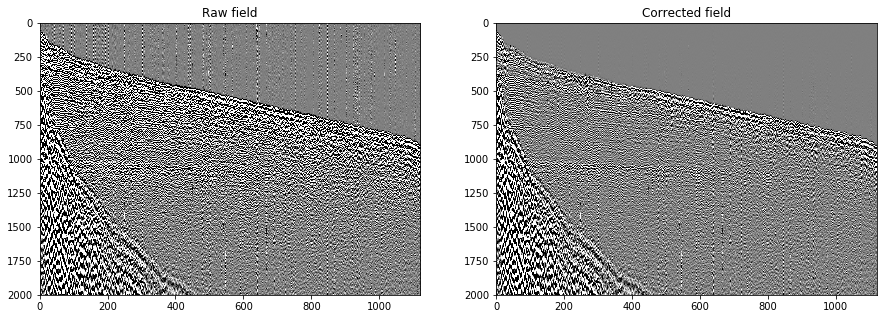

In [5]:
cv = 0.1
seismic_plot([manual_batch.raw[0], manual_batch.corrected[0]], vmin=-cv, vmax=cv,
             cmap='gray', figsize=(15, 5), names=['Raw field', 'Corrected field'])

Gain plot demonstrates this difference in another way. The following plots show the ratio of the maximum mean value of the amplitude to the mean value of the smoothed amplitude at the moment `t`. The goal is to straighten this line.

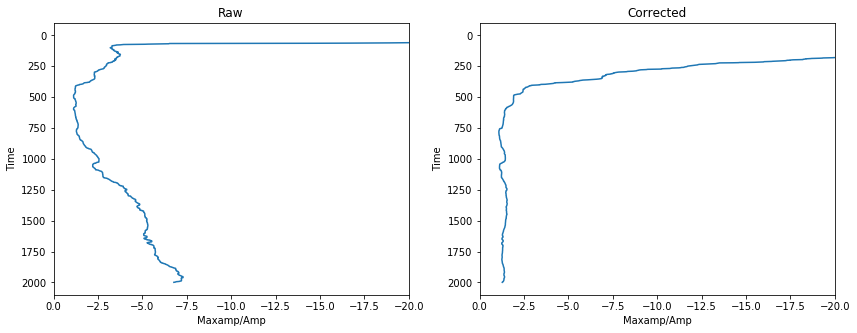

In [6]:
gain_plot([manual_batch.raw[0], manual_batch.corrected[0]], 51, names=['Raw', 'Corrected'],
          figsize=(14, 5), xlim=(0, -20))

Those figures show significant improvement. What about the difference between corrected data and target?

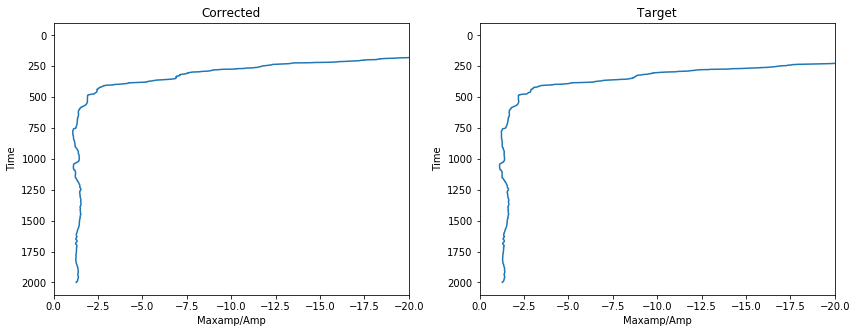

In [7]:
gain_plot([manual_batch.corrected[0], manual_batch.target[0]], 51, names=['Corrected', 'Target'],
          figsize=(14, 5), xlim=(0, -20))

They look very similar.

### 2. Automated estimation
To find parameters for spherical divergence correction one can use ```find_correction_parameters``` function from ```SeismicDataset```. This function minimizes user-defined loss with respect to parameters $V_{pow}$ and $t_{pow}$.```save_to``` argument is useful to save parameters to `Pipeline` of `SeismicDataset` or to `SeismicDataset's` attribute.

Before we start to optimization process, we have to create an instance of `SeismicDataset`.

In [8]:
dataset = SeismicDataset(field_index)

Let's define pipeline that states that we are going to load data and apply spherical convergnce correction. Nothing happens yet, as we state that we want to run pipeline later.

In [9]:
pipeline = (dataset.pipeline()
            .load(fmt='segy', components='raw', tslice=slice(3000))
            .sort_traces(src='raw', dst='raw', sort_by='offset')
            .correct_spherical_divergence(src='raw', dst='corrected',
                                          speed=speed, params=V('sdc_params'))
            .run_later(1, n_iters=1)
)

The whole optimization process will take place only once, prior to the main pipeline, in `Pipeline().before` instance. Estimated parameters will be stored in pipeline variable, so that later we can access them from actions.

In [10]:
(pipeline.before
         .find_sdc_params(component='raw', speed=speed, 
                          loss=calculate_sdc_quality, initial_point=(2, 1),
                          save_to=V('sdc_params'))
);

Let's get a batch from this pipeline:

In [11]:
%%time
optimal_batch = pipeline.next_batch()

CPU times: user 35.3 s, sys: 156 ms, total: 35.5 s
Wall time: 35.4 s


Estimated params are now stored in pipeline variable with name ```sdc_params```. To save result to dataset's attribute use the following named expression: ```D('attribute_name')```.

In [12]:
print("Optimal parameters for v_pow is {:.3}, for t_pow is {:.3}.".format(*pipeline.v('sdc_params')))

Optimal parameters for v_pow is 2.06, for t_pow is 0.998.


Seismograms before and after correction.

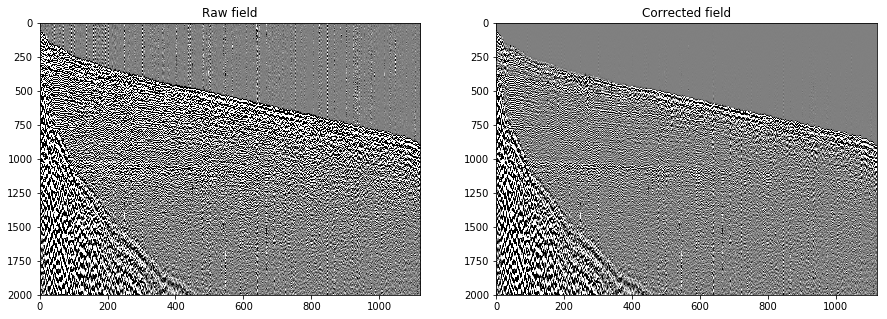

In [13]:
seismic_plot([optimal_batch.raw[0], optimal_batch.corrected[0]], vmin=-cv, vmax=cv,
              cmap='gray', figsize=(15, 5), names=['Raw field', 'Corrected field'])

Gain plots:

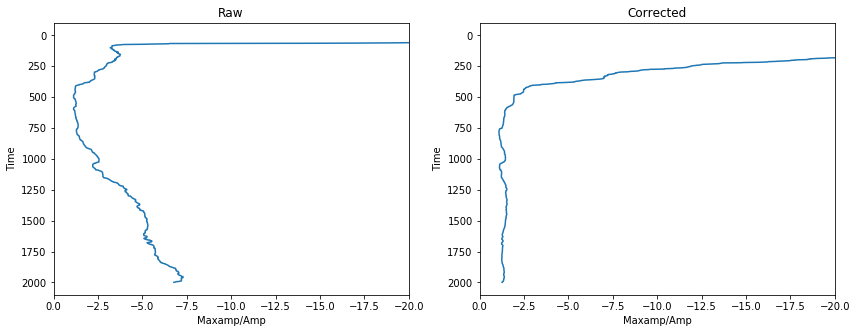

In [14]:
gain_plot([optimal_batch.raw[0], optimal_batch.corrected[0]], 51, names=['Raw', 'Corrected'],
          figsize=(14, 5), xlim=(0, -20))


## Metrics

To measure model's performace we introduce following metrics:
1. Gain plot.

    Gain plot shows the ratio of the maximum mean value of the amplitude to the mean value of the smoothed amplitude at the moment `t`.
2. L1.
3. Derivative metric.

    This metric measures median of the difference between absolute values of the first-order derivative of two adjacent points.

Let's calcualte the difference between this graphs and calculate the metric.

In [15]:
manual = manual_batch.corrected[0]
target = manual_batch.target[0]
raw = manual_batch.raw[0]

print('L1 measure: {:.3}'.format(np.mean(np.abs(manual - target))))
print('DM for raw field: {:.3}'.format(calc_derivative_diff(raw)))
print('DM for manual corr: {:.3}'.format(calc_derivative_diff(manual)))
print('DM for target corr: {:.3}'.format(calc_derivative_diff(target)))

L1 measure: 0.00435
DM for raw field: 0.00398
DM for manual corr: 0.0019
DM for target corr: 0.0021


One can notice that both L1 and difference between our implementation and target is very low.

Let's evaluate the field corrected with optimal parameters. We will not calculate L1 distance between optimal correction and target because they were performed with different parameters, so we'll measue only DM metric for raw and optimally corrected fields:

In [16]:
manual_corr = np.concatenate(optimal_batch.corrected)
raw_corr = np.concatenate(optimal_batch.raw)
print('DM for raw field: {:.3}'.format(calc_derivative_diff(raw_corr)))
print('DM for corrected field with'\
      ' optimal parameters: {:.3}'.format(calc_derivative_diff(manual_corr)))

DM for raw field: 0.00398
DM for corrected field with optimal parameters: 0.0018


DM metric shows that our optimal correction performs better than other other approaches.

## Running time

For Intel i7 we have:
* manual correction with batch size 1 is 500 ms on average.
* automated correction with batch size 1 is 30 seconds on average.

## Criticism
* Loss function may not fully reflect the desired behavior of the gain plot.
* Optimization procedure is quite slow.

## Conclusion
This notebooks introduces two methods for spherical divergence correction implemented in out algorithm. Our optimal correction procedure performs on a par, or even better than conventional approach.

## Suggestions for improvements
Increase the speed of finding the optimal parameters.